In [17]:
from src.summary_lstm.attention import AttentionLayer

#Import the Libraries

In [18]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [19]:
data=pd.read_csv("./dataset/data_text_summary.csv")#, nrows=100000

In [20]:
data.drop_duplicates(subset=['fulltext'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  204 non-null    int64 
 1   summary     204 non-null    object
 2   fulltext    204 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.9+ KB


In [22]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

Tiền xử lý:

1. Lowercase
   
2. Bỏ HTML tags

3. Ánh xạ các cụm từ viết tắt

4. Bỏ (‘s)

5. Bỏ các từ trong ngoặc ( )

6. Bỏ dấu và ký tự đặc biệt (do đây là tiếng anh)

7. Bỏ stopwords



In [23]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\Tam Ngo/nltk_data'
    - 'd:\\Product\\text_summarizer\\.venv\\nltk_data'
    - 'd:\\Product\\text_summarizer\\.venv\\share\\nltk_data'
    - 'd:\\Product\\text_summarizer\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\Tam Ngo\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [ ]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

Bỏ dòng trống

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Tìm hiểu về độ dài và các từ trong câu

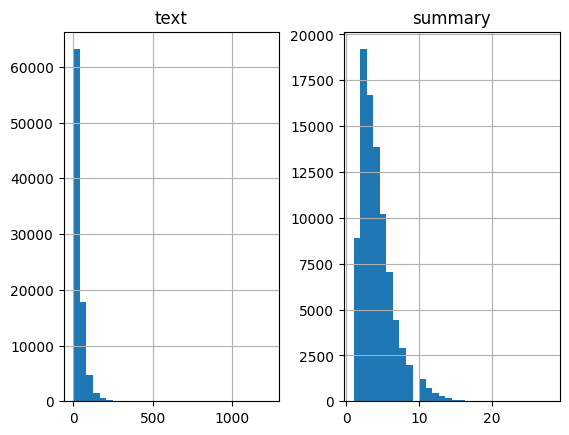

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


94% câu tóm tắt có độ dài không quá 8 từ. Vì thế ta sẽ đặt max_summary_len = 8. Tương tự với max_text_len

In [ ]:
max_text_len=30
max_summary_len=8

Lọc ra những câu có độ dài đáp ứng yêu cầu

In [ ]:
cleaned_text = np.array(data["cleaned_text"])
cleaned_summary = np.array(data["cleaned_summary"])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if (
        len(cleaned_summary[i].split()) <= max_summary_len
        and len(cleaned_text[i].split()) <= max_text_len
    ):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({"text": short_text, "summary": short_summary})

Thêm **START** và **END** tokens vào 2 đầu của summary (**sostok** - start of summary token, **eostok** - end of summary token)

In [ ]:
df["summary"] = df["summary"].apply(lambda x: "sostok " + x + " eostok")

Chia tập train-test (90-10)

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["text"]),
    np.array(df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

Text Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Xác định từ hiếm và độ phủ của chúng

In [ ]:
# threshold = 4 (từ 4 trở xuống là từ hiếm)
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

* **tot_cnt** (total counts): số từ trong bộ vocab
 
*   **cnt**: số lần xuất hiện của những từ không đạt yêu cầu

*  **tot_cnt - cnt**: biểu thị các từ xuất hiện nhiều nhất 

In [ ]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

# padding
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# vocab size (+1 padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

8440

Summary tokenizer

In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

Tương tự text, với threshold = 6

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(42453, 42453)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Build Model

**Return Sequences = True**: Khi return sequences parameter = True, LSTM tạo state_c và state_h cho mỗi timestep

**Return State = True**: Khi return state = True, LSTM tạo state_c và state_h cho timestep cuối

**Initial State**: Khởi tạo states của LSTM cho timestep đầu

**Stacked LSTM**: Stacked LSTM là nhiều lớp LSTM chồng lên nhau. Ở đây, chúng ta sử dụng 3 lớp LSTM cho encoder:

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

# encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Lớp embedding
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
# attn_layer = Attention(name='attention_Layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Nối attention input và decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Lớp dense:
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              844000    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                             

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50

324/324 [==============================] - 459s 1s/step - loss: 3.0021 - val_loss: 2.7275
Epoch 2/50
324/324 [==============================] - 414s 1s/step - loss: 2.6678 - val_loss: 2.7077
Epoch 3/50
324/324 [==============================] - 426s 1s/step - loss: 2.5744 - val_loss: 2.7737
Epoch 4/50
324/324 [==============================] - 438s 1s/step - loss: 2.4990 - val_loss: 2.6139
Epoch 5/50
324/324 [==============================] - 424s 1s/step - loss: 2.4508 - val_loss: 2.6526
Epoch 6/50
324/324 [==============================] - 427s 1s/step - loss: 2.4008 - val_loss: 2.5542
Epoch 7/50
324/324 [==============================] - 415s 1s/step - loss: 2.3607 - val_loss: 2.4336
Epoch 8/50
324/324 [==============================] - 405s 1s/step - loss: 2.3213 - val_loss: 2.3493
Epoch 9/50
324/324 [==============================] - 393s 1s/step - loss: 2.2809 - val_loss: 2.3471
Epoch 10/50
324/324 [==============================] - 412s 1s/step - loss: 2.2430 - val_l

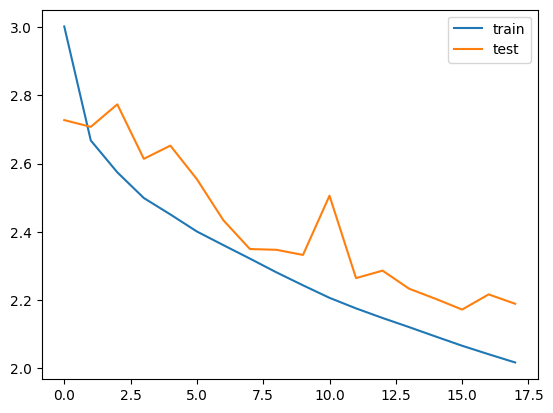

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Inference

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: gave caffeine shakes heart anxiety attack plus tastes unbelievably bad stick coffee tea soda thanks 
Original summary: hour 
1/1 [==============================] - 0s 33ms/step
Predicted summary:  delicious


Review: got great course good belgian chocolates better 
Original summary: would like to give it stars but 
1/1 [==============================] - 0s 48ms/step
Predicted summary:  great product


Review: one best flavored coffees tried usually like flavored coffees one great serve company love 
Original summary: delicious 
1/1 [==============================] - 0s 35ms/step
Predicted summary:  delicious coffee


Review: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging 
1/1 [==============================] - 0s 41ms/step
Predicted summary:  good but not too sweet


Review: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summ

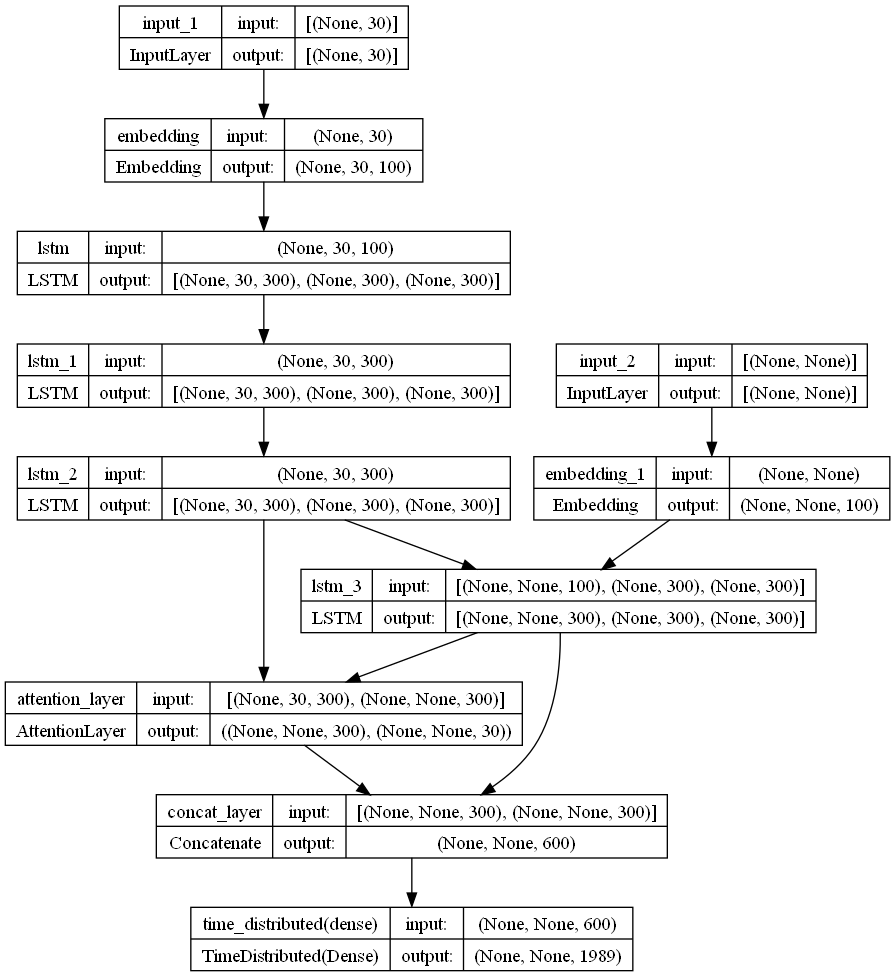

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the Encoder model
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True, show_layer_names=True)

# Plot the Decoder model
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

# Plot the entire Seq2Seq model
plot_model(model, to_file='seq2seq_model.png', show_shapes=True, show_layer_names=True)
